In [11]:
import os
import re
import datetime
import tempfile
import itertools

import seaborn as sns

import numpy as np
import scipy.stats as stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, fclusterdata
import pandas as pd
pd.set_option('display.max_columns', 250)
# Don't cut off long string
# http://stackoverflow.com/questions/26277757/pandas-to-html-truncates-string-contents
pd.set_option('display.max_colwidth', -1)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (16, 9)

# import utils as U

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook combines all `cba.KLEAT` files and merge it with metadata into a master table: `all_cba.KLEAT.with_metadata.csv`

A few things i learned from this notebook:
    1. find the unique items present in listA but absent in listB: setdiff1d
    2. hierarchical clustering method: fclusterdata for NxM matrix.
    3. isin: listA.isin(listB)

In [129]:
# 1. find the unique items present in listA but absent in listB: setdiff1d
# np.setdiff1d?
a = [2,3,3,4]
b = [3,5,7,2]
print(np.setdiff1d(a, b))
print(np.setdiff1d(b, a))

[4]
[5 7]


In [12]:
import pylab
pylab.ion()

data = np.random.randn(2,200)
data[:100,:100] += 10
print(type(data))
print(data.shape)
for i in range(1,15):
    thresh = i/10.
    clusters = hcluster.fclusterdata(numpy.transpose(data), thresh, criterion="distance")
#     clusters = hcluster.fclusterdata(numpy.transpose(data), 2, criterion='maxclust', metric='euclidean', depth=1, method='centroid')
    pylab.scatter(*data[:,:], c=clusters)
    pylab.axis("equal")
    title = "threshold: %f, number of clusters: %d" % (thresh, len(set(clusters)))
    print(title)
    pylab.title(title)
    pylab.draw()
    time.sleep(0.5)
#     pylab.clf()


<class 'numpy.ndarray'>
(2, 200)


NameError: name 'hcluster' is not defined

In [3]:
# * unpack a list, scatter require x and y
a = np.random.randint(1,8, size=(2,5))
a

array([[2, 6, 5, 6, 7],
       [2, 6, 5, 1, 3]])

/projects/trans_scratch/validations/workspace/szong/deep_learning/deep_venv/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


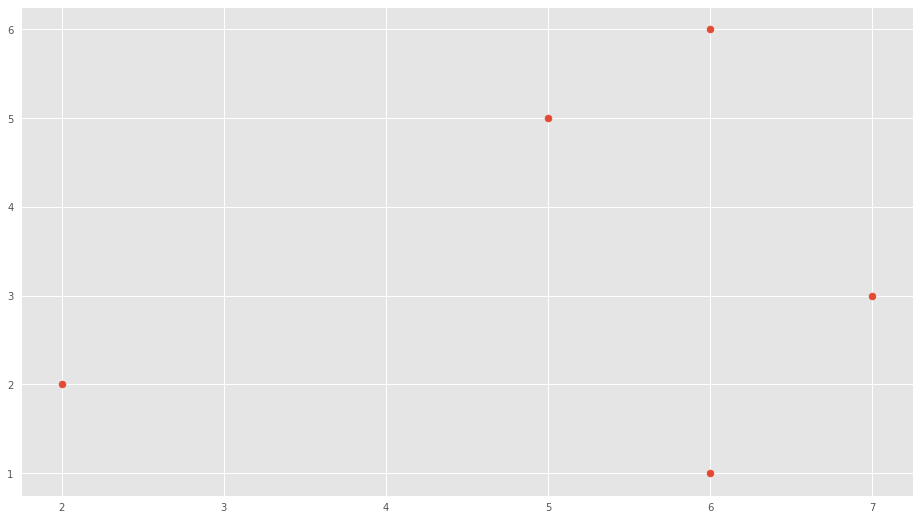

In [4]:
plt.scatter(*a)

In [136]:
x=[[1],[2],[3],[44],[45],[46],[45]]
print(type(x))

# fclusterdata(x,2, criterion='maxclust', metric='euclidean', depth=1, method='centroid')
fclusterdata(x,50, criterion='distance')


<class 'list'>


array([1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [128]:
#  3. isin: df.isin(listB) return boolean indicating if the dataframe values is in listB
# df = pd.DataFrame(np.random.randint(0,100,size=(100, 4)), columns=list('ABCD'))
# np.random.randint(0,100,size=(100, 4)) - creates an output array of size (100,4) with random integer elements between [0,100)
df = pd.DataFrame(np.random.randint(0,10,size=(5, 3)), columns=list('ABC'))
print(df)
b = [3,4,5]
df.isin(b)

   A  B  C
0  1  8  1
1  4  1  0
2  0  2  0
3  9  8  6
4  4  3  7


,A,B,C
0,False,False,False
1,True,False,False
2,False,False,False
3,False,False,False
4,True,True,False


In [7]:
def remove_common_elements(a, b):
    return np.setdiff1d(a, b), np.setdiff1d(b, a)

[4]
[5 7]


In [9]:
def gen_cluster_index(x, window):
    return fclusterdata(x.reshape(-1, 1), 
                        window,
                        criterion='distance',
                        metric='euclidean',
                        method='centroid')

def cluster(x, window=15):
    cluster_idx = gen_cluster_index(x, window)
    dd = {}
    for i in np.unique(cluster_idx):
        vals = x[cluster_idx == i]
        mean = int(vals.mean())
        dd.update(zip(vals, np.repeat(mean, vals.shape[0])))
    return dd


def add_kid(df):
    df['kid'] = (df.chromosome 
          + '-' + df.gene
          + '-' + '(' + df.transcript_strand + ')'
          + '-' + df.transcript
          + '-' + df.cleavage_site.astype(unicode) 
          + '-' + df.kul.astype(unicode))

In [11]:
WINDOW_SIZE = 15 # bp

ONE_SAMPLE_TYPE_DISEASES = ['ACC', 'DLBC', 'LAML', 'MESO', 'UCS', 'UVM']

OUTPUT_FIG_DIR = os.path.join('figs', '114-genes-cond3-15bp-window')

OUTPUT_FIG_DIR

In [15]:
with open('target_genes-one-transcript.txt') as opf:
    ONE_TRANSCRIPT_GENES = [_.strip() for _ in opf.readlines()]

In [17]:
%time qdf = pd.read_csv('qdf-114-genes-cond3.csv')

<string>:2: DtypeWarning: Columns (40,41) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 38.5 s, sys: 9.34 s, total: 47.8 s
Wall time: 48.4 s


In [18]:
qdf.head()

,gene,transcript,transcript_strand,coding,chromosome,cleavage_site,distance_from_annotated_site,length_of_tail_in_contig,number_of_tail_reads,number_of_bridge_reads,max_bridge_read_tail_length,tail+bridge_reads,hexamer_loc+id,3UTR_start_end,flag,kleat_fname,left_coord,right_coord,utr_len,kul,kul_norm,CGHubAnalysisID,AliquotBarcode,AliquotUUID,GCSobject,objectSizeBytes,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,center,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,sample_type_code,analyte_type_code,platform_full_name,sstype,dise
0,RTCA,ENST00000370126,+,yes,chr1,100740463,7978,0,0,2,2,2,100740446:4,-,1,/projects/btl/zxue/tasrkleat-TCGA-results/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz/tasrkleat-results/kleat/cba.KLEAT,100732184,100732485,302,8280.0,27.417219,b0f33684-061e-4253-8895-e7ee3ca8e9f9,TCGA-FU-A5XV-01A-11R-A28H-07,97a13a19-7b9b-4e53-9dfe-6a5836a44510,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz,5971417904,TCGA,TCGA-FU-A5XV-01A-11R-A28H-07,CESC,CERVICAL SQUAMOUS CELL CARCINOMA AND ENDOCERVICAL ADENOCARCINOMA,TP,Primary solid Tumor,RNA,UNC-LCCC,5.971418e+09,e1c9ce14af2f2bcdba031d249250d1d6,b0f33684-061e-4253-8895-e7ee3ca8e9f9,97a13a19-7b9b-4e53-9dfe-6a5836a44510,9dba5a81-3587-4f5a-8d19-e0b0aed0a677,8d5976cf-7e2d-420d-ba18-477a43ccec54,FU,NaN,2013-09-19,2013-09-19,2013-09-19,1,R,Illumina HiSeq 2000,tumour,Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)
1,RTCA,ENST00000260563,+,yes,chr1,100757328,1,0,0,1,6,1,100757305:1,-,1,/projects/btl/zxue/tasrkleat-TCGA-results/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz/tasrkleat-results/kleat/cba.KLEAT,100757060,100757327,268,269.0,1.003731,b0f33684-061e-4253-8895-e7ee3ca8e9f9,TCGA-FU-A5XV-01A-11R-A28H-07,97a13a19-7b9b-4e53-9dfe-6a5836a44510,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz,5971417904,TCGA,TCGA-FU-A5XV-01A-11R-A28H-07,CESC,CERVICAL SQUAMOUS CELL CARCINOMA AND ENDOCERVICAL ADENOCARCINOMA,TP,Primary solid Tumor,RNA,UNC-LCCC,5.971418e+09,e1c9ce14af2f2bcdba031d249250d1d6,b0f33684-061e-4253-8895-e7ee3ca8e9f9,97a13a19-7b9b-4e53-9dfe-6a5836a44510,9dba5a81-3587-4f5a-8d19-e0b0aed0a677,8d5976cf-7e2d-420d-ba18-477a43ccec54,FU,NaN,2013-09-19,2013-09-19,2013-09-19,1,R,Illumina HiSeq 2000,tumour,Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)
2,RTCA,ENST00000260563,+,yes,chr1,100757333,6,9,1,0,0,1,100757305:1,-,1,/projects/btl/zxue/tasrkleat-TCGA-results/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz/tasrkleat-results/kleat/cba.KLEAT,100757060,100757327,268,274.0,1.022388,b0f33684-061e-4253-8895-e7ee3ca8e9f9,TCGA-FU-A5XV-01A-11R-A28H-07,97a13a19-7b9b-4e53-9dfe-6a5836a44510,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz,5971417904,TCGA,TCGA-FU-A5XV-01A-11R-A28H-07,CESC,CERVICAL SQUAMOUS CELL CARCINOMA AND ENDOCERVICAL ADENOCARCINOMA,TP,Primary solid Tumor,RNA,UNC-LCCC,5.971418e+09,e1c9ce14af2f2bcdba031d249250d1d6,b0f33684-061e-4253-8895-e7ee3ca8e9f9,97a13a19-7b9b-4e53-9dfe-6a5836a44510,9dba5a81-3587-4f5a-8d19-e0b0aed0a677,8d5976cf-7e2d-420d-ba18-477a43ccec54,FU,NaN,2013-09-19,2013-09-19,2013-09-19,1,R,Illumina HiSeq 2000,tumour,Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC)
3,NRAS,ENST00000369535,-,yes,chr1,115247084,5,6,

Focus on one disease and one gene for now

In [19]:
# Verified distance_from_annotated_site calculation is correct
minus = qdf[qdf.transcript_strand == '-']

(abs(minus.left_coord - minus.cleavage_site) == minus.distance_from_annotated_site).all()

plus = qdf[qdf.transcript_strand == '+']

(abs(plus.right_coord - plus.cleavage_site) == plus.distance_from_annotated_site).all()

True

In [20]:
def calc_kul(df):
    plus_idx = df[df.transcript_strand == '+'].index
    minus_idx = df[df.transcript_strand == '-'].index

    # init the column
    if 'kul' not in df.columns:
        df['kul'] = -1

    df.loc[plus_idx, 'kul'] = df.loc[plus_idx].cleavage_site - df.loc[plus_idx].left_coord + 1
    df.loc[minus_idx, 'kul'] = df.loc[minus_idx].right_coord - df.loc[minus_idx].cleavage_site + 1

In [21]:
qdf['kul'] = qdf.kul.astype(int)

In [25]:
# fig, axes = plt.subplots(1, 2, figsize=(26, 12), sharey=True)
# ax = jdf[jdf.sstype == 'tumour'].boxplot('kul', by='disease', sym='rs', ax=axes[0], rot=90)
# counts = jdf.groupby('disease').count()['kul'].to_dict()
# texts = [_.get_text() for _ in ax.get_xticklabels()]
# xticks = ['{0} ({1})'.format(k, counts[k]) for k in texts]
# ax.set_xticklabels(xticks)
# ax.set_title('{0} ({1}), tumour, (before removing common clvsites)'.format(
#         gene, jdf.transcript_strand.unique()[0]))

# ax = jdf_uniq[jdf_uniq.sstype == 'tumour'].boxplot('kul', by='disease', sym='rs', ax=axes[1], rot=90)
# counts = jdf_uniq.groupby('disease').count()['kul'].to_dict()
# texts = [_.get_text() for _ in ax.get_xticklabels()]
# xticks = ['{0} ({1})'.format(k, counts[k]) for k in texts]
# ax.set_xticklabels(xticks)
# ax.set_title('{0} ({1}), tumour, (after removing common clvsites)'.format(
#         gene, jdf.transcript_strand.unique()[0]))

# for ax in axes:
#     ax.plot([0, 100], [utr_len, utr_len], '--', label='annotated length')
#     ax.legend(loc='best')
# plt.show()

Disease specific

In [52]:
# ONE_TRANSCRIPT_GENES = ['ABL1']
for gene in ONE_TRANSCRIPT_GENES:
    jdf = qdf[
        (qdf.sample_type.isin(['TP', 'NT'])) 
    #     & (qdf.disease.isin(['KIRP']))
    #     & (qdf.distance_from_annotated_site > 15)
        & (qdf.distance_from_annotated_site < qdf.utr_len)
        & (qdf.gene == gene)
    ].copy()
    
    print(gene, jdf.cleavage_site.unique().shape)
    # unique() is crucial! Otherwise, super slow
    %time clustered = cluster(jdf.cleavage_site.unique())

    # reassigned cleavage_site
    jdf['cleavage_site'] = jdf.cleavage_site.replace(clustered)

    # removing the same cleavage sites
    jdf = jdf.loc[jdf[['cleavage_site', 'kleat_fname']].drop_duplicates().index]

    jdf.shape

    # recalculated kul
    calc_kul(jdf)

    jdf_n = jdf[jdf.sstype == 'normal']
    jdf_t = jdf[jdf.sstype == 'tumour']

    # Clustering cleavage sites directly seems to return the same results
    aa, bb = remove_common_elements(jdf_n.cleavage_site, jdf_t.cleavage_site)

    jdf_uniq = jdf[jdf.cleavage_site.isin(aa) | jdf.cleavage_site.isin(bb)].copy()

    utr_len = jdf.utr_len.unique()[0]

    fig, axes = plt.subplots(1, 2, figsize=(26, 12), sharey=True)

    # Before removing overlapped clvsites
    ax = jdf[jdf.sstype == 'tumour'].boxplot('kul', by='disease', sym='rs', ax=axes[0], rot=90)
    counts = jdf.groupby('disease').count()['kul'].to_dict()
    texts = [_.get_text() for _ in ax.get_xticklabels()]
    xticks = ['{0} ({1})'.format(k, counts[k]) for k in texts]
    ax.set_xticklabels(xticks)
    ax.set_title('{0} ({1}), tumour, (before removing common clvsites)'.format(
            gene, jdf.transcript_strand.unique()[0]))

    ax = jdf_uniq[jdf_uniq.sstype == 'tumour'].boxplot('kul', by='disease', sym='rs', ax=axes[1], rot=90)
    counts = jdf_uniq.groupby('disease').count()['kul'].to_dict()
    texts = [_.get_text() for _ in ax.get_xticklabels()]
    xticks = ['{0} ({1})'.format(k, counts[k]) for k in texts]
    ax.set_xticklabels(xticks)
    ax.set_title('{0} ({1}), tumour, (after removing common clvsites)'.format(
            gene, jdf.transcript_strand.unique()[0]))
    
    for ax in axes:
        ax.plot([0, 100], [utr_len, utr_len], '--', label='annotated length')
        ax.legend(loc='best')
        
    outdir = '/projects/trans_scratch/validations/workspace/szong/python_study'
    output = os.path.join(outdir, '{0}-boxplot-per-disease.png'.format(gene))
    print('saving {0}'.format(output))
    plt.savefig(output)
    plt.close()
#     break

ABL1 (65,)
CPU times: user 3 ms, sys: 0 ns, total: 3 ms
Wall time: 1.94 ms
saving /projects/trans_scratch/validations/workspace/szong/python_study/ABL1-boxplot-per-disease.png


Combine all diseases

In [18]:
for gene in ONE_TRANSCRIPT_GENES:
    jdf = qdf[
        (qdf.sample_type.isin(['TP', 'NT'])) 
    #     & (qdf.disease.isin(['KIRP']))
    #     & (qdf.distance_from_annotated_site > 15)
        & (qdf.distance_from_annotated_site < qdf.utr_len)
        & (qdf.gene == gene)
    ].copy()
    
    print(gene, jdf.cleavage_site.unique().shape)
    # unique() is crucial! Otherwise, super slow
    %time clustered = cluster(jdf.cleavage_site.unique())

    # reassigned cleavage_site
    jdf['cleavage_site'] = jdf.cleavage_site.replace(clustered)

    # removing the same cleavage sites
    jdf = jdf.loc[jdf[['cleavage_site', 'kleat_fname']].drop_duplicates().index]

    jdf.shape

    # recalculated kul
    calc_kul(jdf)

    jdf_n = jdf[jdf.sstype == 'normal']
    jdf_t = jdf[jdf.sstype == 'tumour']

    # Clustering cleavage sites directly seems to return the same results
    aa, bb = remove_common_elements(jdf_n.cleavage_site, jdf_t.cleavage_site)

    jdf_uniq = jdf[jdf.cleavage_site.isin(aa) | jdf.cleavage_site.isin(bb)].copy()

    utr_len = jdf.utr_len.unique()[0]

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Before removing overlapped clvsites
    ax = jdf.boxplot('kul', by='sstype', sym='rs', ax=axes[0])
    counts = jdf.groupby('sstype').count()['kul'].to_dict()
    texts = [_.get_text() for _ in ax.get_xticklabels()]
    xticks = ['{0} ({1})'.format(k, counts[k]) for k in texts]
    ax.set_xticklabels(xticks)
    ax.set_title('{0} ({1}) (before removing common clvsites)'.format(
            gene, jdf.transcript_strand.unique()[0]))

    ax = jdf_uniq.boxplot('kul', by='sstype', sym='rs', ax=axes[1])
    counts = jdf_uniq.groupby('sstype').count()['kul'].to_dict()
    texts = [_.get_text() for _ in ax.get_xticklabels()]
    xticks = ['{0} ({1})'.format(k, counts[k]) for k in texts]
    ax.set_xticklabels(xticks)
    ax.set_title('{0} ({1}) (after removing common clvsites)'.format(
            gene, jdf.transcript_strand.unique()[0]))
    
    for ax in axes:
        ax.plot([0, 100], [utr_len, utr_len], '--', label='annotated length')
        ax.legend(loc='best')
        
    outdir = '/projects/trans_scratch/validations/workspace/szong/python_study'
    output = os.path.join(outdir, '{0}-boxplot.png'.format(gene))
    print('saving {0}'.format(output))
    plt.savefig(output)
    plt.cla()
    plt.close()

ABL1 (65,)
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.95 ms
saving /projects/trans_scratch/validations/workspace/szong/python_study/ABL1-boxplot.png
CARD11 (30,)
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 1.26 ms
saving /projects/trans_scratch/validations/workspace/szong/python_study/CARD11-boxplot.png
CEBPA (80,)
CPU times: user 2 ms, sys: 0 ns, total: 2 ms
Wall time: 2.13 ms
saving /projects/trans_scratch/validations/workspace/szong/python_study/CEBPA-boxplot.png
EP300 (189,)
CPU times: user 5 ms, sys: 0 ns, total: 5 ms
Wall time: 4.53 ms
saving /projects/trans_scratch/validations/workspace/szong/python_study/EP300-boxplot.png
IGF2BP1 (144,)
CPU times: user 6 ms, sys: 0 ns, total: 6 ms
Wall time: 4.92 ms
saving /projects/trans_scratch/validations/workspace/szong/python_study/IGF2BP1-boxplot.png
JUN (381,)
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 10.1 ms
saving /projects/trans_scratch/validations/workspace/szong/python_study/JUN-boxplot.png

In [17]:
gene = 'EP300'

jdf = qdf[
    (qdf.sample_type.isin(['TP', 'NT'])) 
#     & (qdf.disease.isin(['KIRP']))
#     & (qdf.distance_from_annotated_site > 15)
    & (qdf.distance_from_annotated_site < qdf.utr_len)
    & (qdf.gene == gene)
].copy()

In [18]:
jdf.cleavage_site.unique().shape

(189,)

In [19]:
jdf.utr_len.unique()

array([1122])

In [20]:
# unique() is crucial! Otherwise, super slow
%time clustered = cluster(jdf.cleavage_site.unique())

CPU times: user 5.5 ms, sys: 17 µs, total: 5.51 ms
Wall time: 4.77 ms


In [21]:
# reassigned cleavage_site
jdf['cleavage_site'] = jdf.cleavage_site.replace(clustered)

In [22]:
jdf.shape

(15243, 50)

In [25]:
jdf = jdf.loc[jdf[['cleavage_site', 'kleat_fname']].drop_duplicates().index]

In [26]:
jdf.shape

(11979, 50)

In [27]:
utr_len = jdf.utr_len.unique()[0]

In [28]:
# recalculated kul
calc_kul(jdf)

In [29]:
jdf_n = jdf[jdf.sstype == 'normal']
jdf_t = jdf[jdf.sstype == 'tumour']

In [30]:
# Clustering cleavage sites directly seems to return the same results
aa, bb = remove_common_elements(jdf_n.cleavage_site, jdf_t.cleavage_site)

In [31]:
jdf_uniq = jdf[jdf.cleavage_site.isin(aa) | jdf.cleavage_site.isin(bb)].copy()

In [32]:
jdf_uniq.shape

(78, 50)

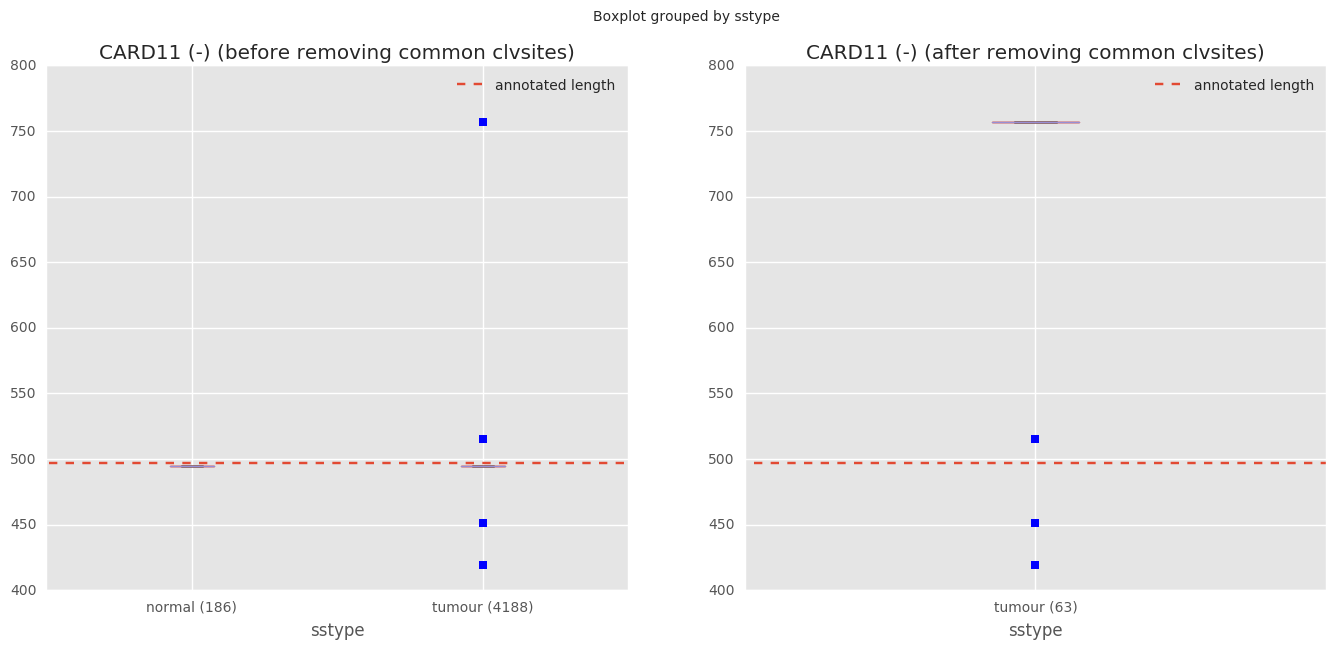

In [392]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Before removing overlapped clvsites
ax = jdf.boxplot('kul', by='sstype', sym='rs', ax=axes[0])
counts = jdf.groupby('sstype').count()['kul'].to_dict()
texts = [_.get_text() for _ in ax.get_xticklabels()]
xticks = ['{0} ({1})'.format(k, counts[k]) for k in texts]
ax.set_xticklabels(xticks)
ax.set_title('{0} ({1}) (before removing common clvsites)'.format(
        gene, jdf.transcript_strand.unique()[0]))

ax = jdf_uniq.boxplot('kul', by='sstype', sym='rs', ax=axes[1])
counts = jdf_uniq.groupby('sstype').count()['kul'].to_dict()
texts = [_.get_text() for _ in ax.get_xticklabels()]
xticks = ['{0} ({1})'.format(k, counts[k]) for k in texts]
ax.set_xticklabels(xticks)
ax.set_title('{0} ({1}) (after removing common clvsites)'.format(
        gene, jdf.transcript_strand.unique()[0]))

for ax in axes:
    ax.plot([0, 100], [utr_len, utr_len], '--', label='annotated length')
    ax.legend(loc='best')

In [393]:
jdf.transcript.value_counts()

ENST00000396946    4374
Name: transcript, dtype: int64

In [395]:
jdf[jdf.gene == gene].kleat_fname.head(1)

552    /projects/btl/zxue/tasrkleat-TCGA-results/tcga/LUSC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2214797.76ad7c60-3911-478f-bb99-2161769fa380.110127_UNC9-SN296_0123_A81CV9ABXX_5.tar.gz/tasrkleat-results/kleat/cba.KLEAT
Name: kleat_fname, dtype: object

In [396]:
jdf.cleavage_site.value_counts().head(5)

2945776    4311
2945514    49  
2945820    8   
2945756    5   
2945852    1   
Name: cleavage_site, dtype: int64

In [398]:
jdf_uniq.cleavage_site.value_counts().head(5)

2945514    49
2945820    8 
2945756    5 
2945852    1 
Name: cleavage_site, dtype: int64

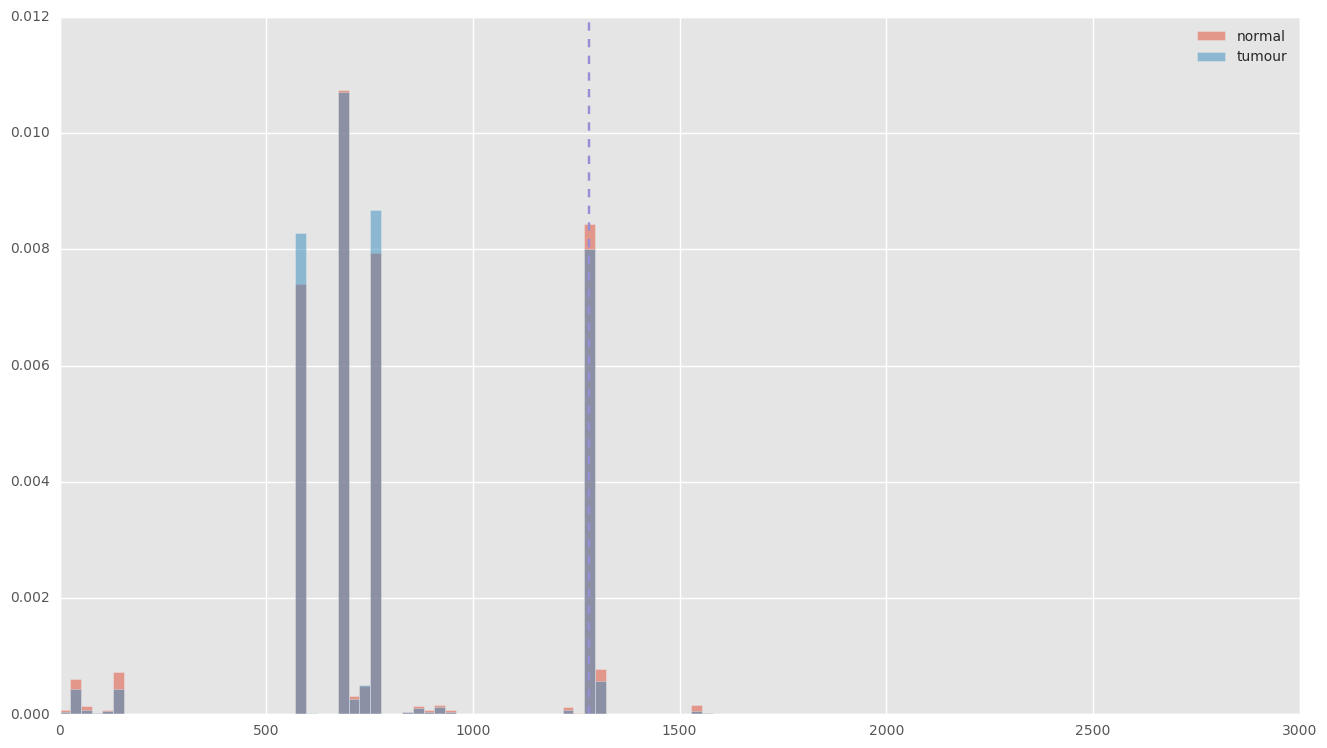

In [174]:
bins = np.linspace(0, 2 * UTR_LEN, 100)
ax = jdf_n.kul.hist(bins=bins, normed=True, alpha=0.5, label='normal')
jdf_t.kul.hist(bins=bins, normed=True, alpha=0.5, label='tumour')
y = ax.get_ylim()[-1]
ax.plot([UTR_LEN, UTR_LEN], [0, y], '--')
ax.legend()

In [22]:
# def get_normal_unique_kuls(rdf):
#     sdf = rdf[['kid', 'transcript', 'transcript_strand', 'kul', 'utr_len',
#            'participant_id', 'barcode', 'sample_type']].copy()
#     sdf.drop_duplicates(inplace=True)
#     sdf_normal = sdf[sdf.sample_type == 'NT']
#     sdf_tumour = sdf[sdf.sample_type == 'TP']
#     uniq_n, uniq_t = remove_common_elements(sdf_normal.kid.unique(), sdf_tumour.kid.unique())
#     print(rdf.disease.unique()[0], uniq_n.shape[0], uniq_t.shape[0])
#     count = sdf[sdf.kid.isin(uniq_n)].groupby('kid').count()
#     return sdf[sdf.kid.isin(count[count >= 2].index)][['kid', 'kul']]

In [24]:
# tdf_n = grps.apply(get_normal_unique_kuls)

In [131]:
def get_tumour_unique_kuls(rdf):
    sdf = rdf[['kid', 'transcript', 'transcript_strand', 'kul', 'utr_len',
           'participant_id', 'barcode', 'sample_type']].copy()
    sdf.drop_duplicates(inplace=True)
    sdf_normal = sdf[sdf.sample_type == 'NT']
    sdf_tumour = sdf[sdf.sample_type == 'TP']
    uniq_n, uniq_t = remove_common_elements(sdf_normal.kid.unique(), sdf_tumour.kid.unique())
    print(rdf.disease.unique()[0], uniq_n.shape[0], uniq_t.shape[0])
    count = sdf[sdf.kid.isin(uniq_t)].groupby('kid').count()
    return sdf[sdf.kid.isin(count[count >= 2].index)][['kid', 'cleavage_site']]

In [136]:
_qdf = qdf[
    (qdf.sample_type.isin(['TP', 'NT'])) 
#     & (qdf.disease.isin(['KIRP']))
    & (qdf.distance_from_annotated_site > 15)
    & (qdf.distance_from_annotated_site < qdf.utr_len)
    & (qdf.gene == 'PIK3CA')
]

In [140]:
_qdf[_qdf.kul < 5000].head()

,gene,transcript,transcript_strand,coding,chromosome,cleavage_site,distance_from_annotated_site,length_of_tail_in_contig,number_of_tail_reads,number_of_bridge_reads,max_bridge_read_tail_length,tail+bridge_reads,hexamer_loc+id,3UTR_start_end,flag,kleat_fname,left_coord,right_coord,utr_len,kul,kul_norm,CGHubAnalysisID,AliquotBarcode,AliquotUUID,GCSobject,objectSizeBytes,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,center,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,sample_type_code,analyte_type_code,platform_full_name,sstype,dise,kid
47,PIK3CA,ENST00000263967,+,yes,chr3,178952774,5107,0,0,2,4,2,178952753:1,-,1,/projects/btl/zxue/tasrkleat-TCGA-results/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz/tasrkleat-results/kleat/cba.KLEAT,178952152,178957881,5730,623,0.108726,b0f33684-061e-4253-8895-e7ee3ca8e9f9,TCGA-FU-A5XV-01A-11R-A28H-07,97a13a19-7b9b-4e53-9dfe-6a5836a44510,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz,5971417904,TCGA,TCGA-FU-A5XV-01A-11R-A28H-07,CESC,CERVICAL SQUAMOUS CELL CARCINOMA AND ENDOCERVICAL ADENOCARCINOMA,TP,Primary solid Tumor,RNA,UNC-LCCC,5.971418e+09,e1c9ce14af2f2bcdba031d249250d1d6,b0f33684-061e-4253-8895-e7ee3ca8e9f9,97a13a19-7b9b-4e53-9dfe-6a5836a44510,9dba5a81-3587-4f5a-8d19-e0b0aed0a677,8d5976cf-7e2d-420d-ba18-477a43ccec54,FU,NaN,2013-09-19,2013-09-19,2013-09-19,1,R,Illumina HiSeq 2000,tumour,Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC),chr3-PIK3CA-(+)-ENST00000263967-178952774-623
48,PIK3CA,ENST00000263967,+,yes,chr3,178955281,2600,0,0,4,7,4,178955273:6,-,1,/projects/btl/zxue/tasrkleat-TCGA-results/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz/tasrkleat-results/kleat/cba.KLEAT,178952152,178957881,5730,3130,0.546248,b0f33684-061e-4253-8895-e7ee3ca8e9f9,TCGA-FU-A5XV-01A-11R-A28H-07,97a13a19-7b9b-4e53-9dfe-6a5836a44510,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz,5971417904,TCGA,TCGA-FU-A5XV-01A-11R-A28H-07,CESC,CERVICAL SQUAMOUS CELL CARCINOMA AND ENDOCERVICAL ADENOCARCINOMA,TP,Primary solid Tumor,RNA,UNC-LCCC,5.971418e+09,e1c9ce14af2f2bcdba031d249250d1d6,b0f33684-061e-4253-8895-e7ee3ca8e9f9,97a13a19-7b9b-4e53-9dfe-6a5836a44510,9dba5a81-3587-4f5a-8d19-e0b0aed0a677,8d5976cf-7e2d-420d-ba18-477a43ccec54,FU,NaN,2013-09-19,2013-09-19,2013-09-19,1,R,Illumina HiSeq 2000,tumour,Cervical squamous cell carcinoma and endocervical adenocarcinoma (CESC),chr3-PIK3CA-(+)-ENST00000263967-178955281-3130
49,PIK3CA,ENST00000263967,+,yes,chr3,178955387,2494,0,0,1,4,1,178955359:14,-,1,/projects/btl/zxue/tasrkleat-TCGA-results/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz/tasrkleat-results/kleat/cba.KLEAT,178952152,178957881,5730,3236,0.564747,b0f33684-061e-4253-8895-e7ee3ca8e9f9,TCGA-FU-A5XV-01A-11R-A28H-07,97a13a19-7b9b-4e53-9dfe-6a5836a44510,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/CESC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2169014.97a13a19-7b9b-4e53-9dfe-6a5836a44510.130606_UNC9-SN296_0373_BD28T1ACXX_6_CTTGTA.tar.gz,5971417904,TCGA,TCGA-FU-A5XV-01A-11R-A28H-07,CESC,CERVICAL SQUAMOUS CELL CARCINOMA AND ENDOCERVICAL ADENOCARCINOMA,TP,Primary solid Tumor,RNA,UNC-LCCC,5.971418e+09,e1c9ce14af2f2bcdba031d249250d1d6,b0f33684-061e-4253-8895-e7ee3ca8e9f9,97a13a19-7b9b-4e53-9dfe-6a5836a44510,9dba5a81-3587-4f5a-8d19-e0b0aed0a677,8d5976cf-7e2d-420d-ba18-477a43ccec54,FU,NaN,2013-09-19,2013-09-19,2013-09-19,1,R,Illumina HiSeq 2000,tumour,Cervical s

In [88]:
UTR_LEN = _qdf..unique()[0]

In [89]:
UTR_LEN

438

In [90]:
grps = _qdf.groupby('disease')

In [91]:
qdf[
    (qdf.sample_type.isin(['TP', 'NT'])) 
#     & (qdf.disease.isin(['KIRP']))
    & (qdf.distance_from_annotated_site > 15)
    & (qdf.distance_from_annotated_site < qdf.utr_len)
    & (qdf.gene == 'SOCS1')
].sample_type_name.value_counts()

Primary solid Tumor    1991
Solid Tissue Normal    134 
Name: sample_type_name, dtype: int64

In [95]:
# grps.apply(lambda g: g.sample_type_name.value_counts())

In [96]:
tdf = grps.apply(get_tumour_unique_kuls)

('ACC', 0, 6)
('ACC', 0, 6)
('BLCA', 1, 7)
('BRCA', 0, 6)
('CESC', 0, 9)
('CHOL', 0, 3)
('COAD', 0, 4)
('DLBC', 0, 4)
('ESCA', 0, 12)
('GBM', 0, 4)
('HNSC', 0, 7)
('KICH', 0, 2)
('KIRC', 2, 6)
('KIRP', 0, 4)
('LGG', 0, 4)
('LIHC', 1, 4)
('LUAD', 1, 4)
('LUSC', 1, 6)
('MESO', 0, 2)
('OV', 0, 14)
('PAAD', 0, 5)
('PCPG', 0, 3)
('PRAD', 1, 3)
('READ', 0, 2)
('SARC', 0, 7)
('SKCM', 0, 3)
('STAD', 0, 16)
('TGCT', 0, 5)
('THCA', 2, 7)
('THYM', 0, 10)
('UCEC', 1, 2)
('UCS', 0, 8)
('UVM', 0, 1)


In [102]:
qdf[(qdf.gene == 'SOCS1') & (qdf.kul == 731)].head(1)

,gene,transcript,transcript_strand,coding,chromosome,cleavage_site,distance_from_annotated_site,length_of_tail_in_contig,number_of_tail_reads,number_of_bridge_reads,max_bridge_read_tail_length,tail+bridge_reads,hexamer_loc+id,3UTR_start_end,flag,kleat_fname,left_coord,right_coord,utr_len,kul,kul_norm,CGHubAnalysisID,AliquotBarcode,AliquotUUID,GCSobject,objectSizeBytes,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,center,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,sample_type_code,analyte_type_code,platform_full_name,sstype,dise,kid
7468,SOCS1,ENST00000332029,-,yes,chr16,11347968,293,0,0,1,8,1,11347989:4,-,1,/projects/btl/zxue/tasrkleat-TCGA-results/tcga/KICH/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2186271.17238de6-eab7-47ed-948e-be06ee5de5b7.121106_UNC11-SN627_0259_BD16TJACXX_2_CCGTCC.tar.gz/tasrkleat-results/kleat/cba.KLEAT,11348261,11348698,438,731,1.66895,7c14fa65-4e1a-40e7-b865-28af3912136b,TCGA-KN-8434-01A-11R-2315-07,17238de6-eab7-47ed-948e-be06ee5de5b7,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/KICH/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2186271.17238de6-eab7-47ed-948e-be06ee5de5b7.121106_UNC11-SN627_0259_BD16TJACXX_2_CCGTCC.tar.gz,6905337154,TCGA,TCGA-KN-8434-01A-11R-2315-07,KICH,KIDNEY CHROMOPHOBE,TP,Primary solid Tumor,RNA,UNC-LCCC,6.905337e+09,728e390c3ba4c8a02acd875b2b713fc2,7c14fa65-4e1a-40e7-b865-28af3912136b,17238de6-eab7-47ed-948e-be06ee5de5b7,e1e15226-9f8e-4035-8f08-eb1fed57080e,f75de9fc-5de8-4cae-b1e1-8c37d1915c17,KN,NaN,2013-09-15,2013-09-15,2013-09-15,1,R,Illumina HiSeq 2000,tumour,Kidney chromophobe (KICH),chr16-SOCS1-(-)-ENST00000332029-11347968-731


In [101]:
tdf[tdf.disease == 'KIRC']

,disease,kid,kul
306,KIRC,chr16-SOCS1-(-)-ENST00000332029-11348293-406,406
307,KIRC,chr16-SOCS1-(-)-ENST00000332029-11347968-731,731
308,KIRC,chr16-SOCS1-(-)-ENST00000332029-11347965-734,734
309,KIRC,chr16-SOCS1-(-)-ENST00000332029-11347965-734,734
310,KIRC,chr16-SOCS1-(-)-ENST00000332029-11348284-415,415
311,KIRC,chr16-SOCS1-(-)-ENST00000332029-11348239-460,460
312,KIRC,chr16-SOCS1-(-)-ENST00000332029-11348277-422,422


In [98]:
tdf.index = tdf.index.droplevel(1)
tdf.reset_index(inplace=True)

In [103]:
tdf.head(2)

,disease,kid,kul
0,ACC,chr16-SOCS1-(-)-ENST00000332029-11348282-417,417
1,ACC,chr16-SOCS1-(-)-ENST00000332029-11348285-414,414


In [119]:
texts = [_.get_text() for _ in ax.get_xticklabels()]

xs = ax.get_xticks()

counts = tdf.groupby('disease').count()['kid'].to_dict()

In [123]:
ax.get_ylim()[-1]

900.0

In [ ]:
ax.set_xticks

In [128]:
ax.set_xticks?

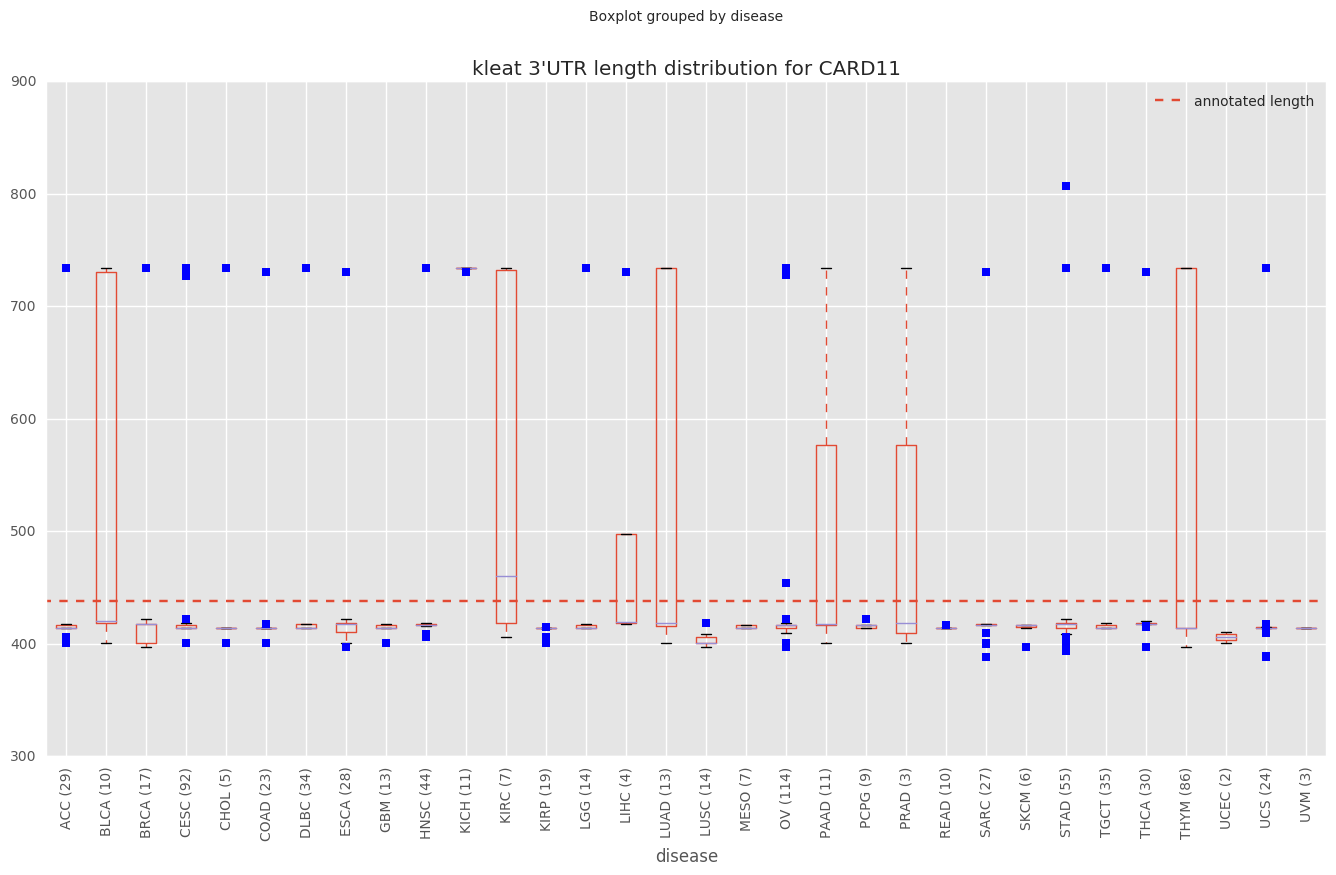

In [130]:
ax = tdf.boxplot('kul', by='disease', sym='rs', rot=90)
ax.set_title("kleat 3'UTR length distribution for CARD11")
ax.plot([0, 100], [UTR_LEN, UTR_LEN], '--', label='annotated length')
texts = [_.get_text() for _ in ax.get_xticklabels()]
y = ax.get_ylim()[-1] - 20
xs = ax.get_xticks()
counts = tdf.groupby('disease').count()['kid'].to_dict()
# for x, k in zip(xs, texts):
#     ax.(x, y, '{0}'.format(counts[k]))
xticks = ['{0} ({1})'.format(k, counts[k]) for k in texts]
ax.set_xticklabels(xticks)
ax.legend(loc='best')

In [289]:
INTEREST = ['ACC', 'MESO', 'SARC', 'THYM']

In [302]:
plt.boxplot?

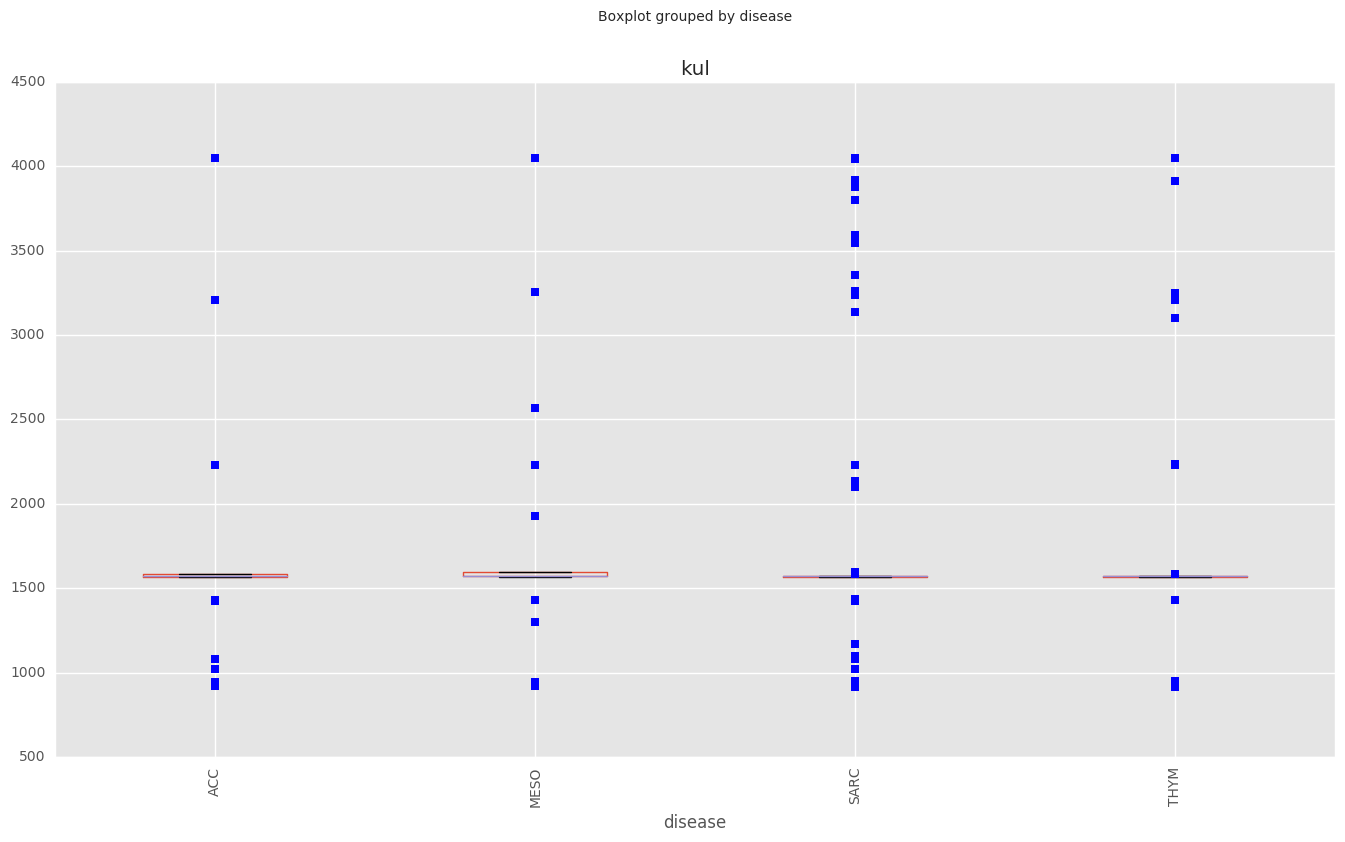

In [306]:
tdf[tdf.disease.isin(INTEREST)].boxplot('kul', by='disease', sym='rs', rot=90)

In [253]:
_df = qdf.groupby('disease').apply(lambda x: x.sample_type.unique().shape[0])

In [240]:
_df = qdf.groupby('disease').apply(lambda x: x[['sample_type', 'sample_type_name']].drop_duplicates())

In [256]:
_df[_df == 1].index.values

array(['ACC', 'DLBC', 'LAML', 'MESO', 'UCS', 'UVM'], dtype=object)

In [20]:
grp.index.unique()[0]

199

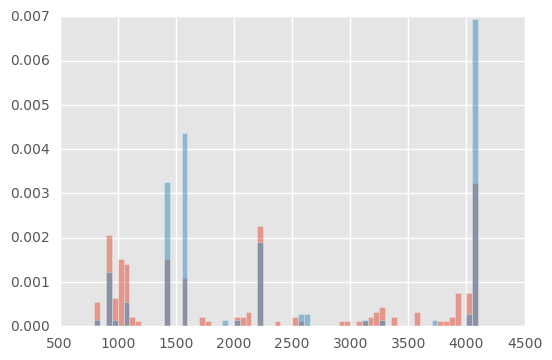

In [629]:
ax = bkul.hist(bins=np.arange(800, 4500, 50), alpha=0.5, normed=True)
kkul.hist(bins=np.arange(800, 4500, 50), alpha=0.5, normed=True, ax=ax)

In [630]:
rdf.kleat_fname.head(2)

199       /projects/btl/zxue/tasrkleat-TCGA-results/tcga/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2209362.b3ac6331-6c8f-4165-add7-482aadf7fa68.110506_UNC9-SN296_0179_AB0BEFABXX_5.tar.gz/tasrkleat-results/kleat/cba.KLEAT        
227714    /projects/btl/zxue/tasrkleat-TCGA-results/tcga/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2185669.176b2422-3599-41c5-be62-ae6e28d60b90.121205_UNC14-SN744_0276_AC19W1ACXX_6_CAGATC.tar.gz/tasrkleat-results/kleat/cba.KLEAT
Name: kleat_fname, dtype: object